# Brain Tumor


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Mon Dec 21 09:56:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import os
import cv2
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [ ]:
x_dataset=[]
y_dataset=[]
for i in range(len(os.listdir("/content/drive/My Drive/brainTumorData"))):
    file=h5py.File("/content/drive/My Drive/brainTumorData"+str(i+1)+".mat",mode='r')
    Dataset=file["cjdata/image"]
    Label=file["cjdata/label"]
    x=np.array(Dataset,dtype='float32')
    y=np.array(Label,dtype='float32')
    x=scaler.fit_transform(x)
    x=np.repeat(x[:,:,np.newaxis],3,axis=2)
    x=cv2.resize(x,(224,224))
    x_dataset.append(x)
    y_dataset.append(y)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

OSError: ignored

In [ ]:
X_dataset=np.array(x_dataset)
Y_dataset=np.array(y_dataset)
Y_dataset=Y_dataset.reshape((3064,1))

Y_dataset=Y_dataset-1

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds=list(StratifiedKFold(n_splits=8,shuffle=True,random_state=1).split(X_dataset,Y_dataset))

In [ ]:
#from keras.utils.vis_utils import plot_model

VGG=tf.keras.applications.VGG16(include_top=False,input_shape=(224,224,3))
input_image=tf.keras.layers.Input((224,224,3))
x= VGG (input_image)
#plot_model(x)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(3)(x)
out=tf.keras.layers.Activation(activation='softmax')(x)

model=tf.keras.Model(inputs=input_image,outputs=out)

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 75267     
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 14,789,955
Trainable params: 14,789,955
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc,roc_curve

In [ ]:
History=[]
Prescore=[]
Recall=[]
F1=[]
Sensspeci=[]
Roc_auc=[]
for j,(train_idx,val_idx) in enumerate(folds):
    print("Fold "+str(j+1))
    
    x_train=X_dataset[train_idx]
    y_train=Y_dataset[train_idx]
    x_val=X_dataset[val_idx]
    y_val=Y_dataset[val_idx]
    history=model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_val,y_val))
    y_predict=model.predict(x_val)
    Y_predict=np.argmax(y_predict,axis=1)
    l=len(y_val)
    Y_predict=np.reshape(Y_predict,(l,1))
    prescore=precision_score(y_val,Y_predict,average=None)
    recaller=recall_score(y_val,Y_predict,average=None)
    score=f1_score(y_val,Y_predict,average=None)
    sensitivity=sensitivity_specificity_support(y_val,Y_predict,average=None)
    lb=label_binarize(y_val,classes=[0,1,2])
    lb1=label_binarize(Y_predict,classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
      fpr[i], tpr[i], _ = roc_curve(lb[:, i], lb1[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
    
    print("Precision: ",prescore)
    print("Recall: ",recaller)
    print("F1-score ",score)
    print("Sensitivity ",sensitivity)
    History.append(history)
    Prescore.append(prescore)
    F1.append(score)
    Recall.append(recaller)
    Sensspeci.append(sensitivity)
    Roc_auc.append(roc_auc)

Fold 1
Epoch 1/15
84/84 [==============================] - 20s 240ms/step - loss: 1091.8849 - accuracy: 0.5076 - val_loss: 0.7677 - val_accuracy: 0.6658
Epoch 2/15
84/84 [==============================] - 18s 212ms/step - loss: 1.5259 - accuracy: 0.5628 - val_loss: 0.7987 - val_accuracy: 0.6606
Epoch 3/15
84/84 [==============================] - 18s 212ms/step - loss: 1.0117 - accuracy: 0.6158 - val_loss: 0.5341 - val_accuracy: 0.8120
Epoch 4/15
84/84 [==============================] - 18s 212ms/step - loss: 0.5953 - accuracy: 0.7658 - val_loss: 0.9185 - val_accuracy: 0.6710
Epoch 5/15
84/84 [==============================] - 18s 212ms/step - loss: 0.5480 - accuracy: 0.8068 - val_loss: 0.4441 - val_accuracy: 0.8407
Epoch 6/15
84/84 [==============================] - 18s 212ms/step - loss: 0.4406 - accuracy: 0.8404 - val_loss: 0.3898 - val_accuracy: 0.8486
Epoch 7/15
84/84 [==============================] - 18s 212ms/step - loss: 0.3865 - accuracy: 0.8616 - val_loss: 0.3257 - val_accura

In [ ]:
acc=History[0].history['accuracy']
acc1=History[1].history['accuracy']
acc2=History[2].history['accuracy']
acc3=History[3].history['accuracy']
acc4=History[4].history['accuracy']
acc5=History[5].history['accuracy']
acc6=History[6].history['accuracy']
acc7=History[7].history['accuracy']
Accuracy1=acc[9]
Accuracy2=acc1[9]
Accuracy3=acc2[9]
Accuracy4=acc3[9]
Accuracy5=acc4[9]
Accuracy6=acc5[9]
Accuracy7=acc6[9]
Accuracy8=acc7[9]
Mean_Accuracy=(Accuracy1+Accuracy2+Accuracy3+Accuracy4)/4.00
val_acc=History[0].history['val_accuracy']
val_acc1=History[1].history['val_accuracy']
val_acc2=History[2].history['val_accuracy']
val_acc3=History[3].history['val_accuracy']
val_acc4=History[4].history['val_accuracy']
val_acc5=History[5].history['val_accuracy']
val_acc6=History[6].history['val_accuracy']
val_acc7=History[7].history['val_accuracy']
Accuracyvalid1=val_acc[9]
Accuracyvalid2=val_acc1[9]
Accuracyvalid3=val_acc2[9]
Accuracyvalid4=val_acc3[9]
Accuracyvalid5=val_acc4[9]
Accuracyvalid6=val_acc5[9]
Accuracyvalid7=val_acc6[9]
Accuracyvalid8=val_acc7[9]
Mean_valid_Accuracy=(Accuracyvalid1+Accuracyvalid2+Accuracyvalid3+Accuracyvalid4)/4.00
print("Accuracy for Fold-1 ",Accuracy1)
print("validation Accuracy for Fold-1 ",Accuracyvalid1)
print("Accuracy for Fold-2",Accuracy2)
print("validation Accuracy for Fold-2",Accuracyvalid2)
print("Accuracy for Fold-3 ",Accuracy3)
print("Validation Accuracy for Fold-3 ",Accuracyvalid3)
print("Accuracy for Fold-4  ",Accuracy4)
print("Validation Accuracy for Fold-4  ",Accuracyvalid4)
print("Accuracy for Fold-5  ",Accuracy5)
print("Validation Accuracy for Fold-5  ",Accuracyvalid5)
print("Accuracy for Fold-6  ",Accuracy6)
print("Validation Accuracy for Fold-6  ",Accuracyvalid6)
print("Accuracy for Fold-7  ",Accuracy7)
print("Validation Accuracy for Fold-7  ",Accuracyvalid7)
print("Accuracy for Fold-8  ",Accuracy8)
print("Validation Accuracy for Fold-8  ",Accuracyvalid8)
print("Mean Accuracy ",Mean_Accuracy)
print("Mean Validation Accuracy ",Mean_valid_Accuracy)

Accuracy for Fold-1  0.8963073492050171
validation Accuracy for Fold-1  0.8250652551651001
Accuracy for Fold-2 0.9295039176940918
validation Accuracy for Fold-2 0.942558765411377
Accuracy for Fold-3  0.9388287663459778
Validation Accuracy for Fold-3  0.9686684012413025
Accuracy for Fold-4   0.9548676013946533
Validation Accuracy for Fold-4   0.9791122674942017
Accuracy for Fold-5   0.9623274803161621
Validation Accuracy for Fold-5   0.934725821018219
Accuracy for Fold-6   0.9574785232543945
Validation Accuracy for Fold-6   0.9843342304229736
Accuracy for Fold-7   0.9813502430915833
Validation Accuracy for Fold-7   0.937336802482605
Accuracy for Fold-8   0.9735173583030701
Validation Accuracy for Fold-8   0.9765012860298157
Mean Accuracy  0.929876908659935
Mean Validation Accuracy  0.9288511723279953


In [ ]:
print("Printing the precision scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(8):
  print("Precision of Fold -1",Prescore[i])
  avgm=avgm+Prescore[i][0]
  avgg=avgg+Prescore[i][1]
  avgp=avgp+Prescore[i][2]

print("Average Meningioma ",avgm/8.0)
print("Average Glioma ",avgg/8.0)
print("Average Pituitary ",avgp/8.0)

Printing the precision scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.78723404 0.90502793 0.97272727]
Precision of Fold -1 [0.73043478 0.96385542 1.        ]
Precision of Fold -1 [0.92647059 0.86633663 0.98230088]
Precision of Fold -1 [0.77678571 0.99346405 0.97457627]
Precision of Fold -1 [0.93023256 0.97191011 0.97478992]
Precision of Fold -1 [0.96590909 0.97777778 1.        ]
Precision of Fold -1 [0.8019802  0.89473684 1.        ]
Precision of Fold -1 [0.90625    0.98823529 0.98290598]
Average Meningioma  0.8531621218439154
Average Glioma  0.9451680083698534
Average Pituitary  0.9859125409677294


In [ ]:
print("Printing the Recall scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(8):
  print("Precision of Fold -1",Recall[i])
  avgm=avgm+Recall[i][0]
  avgg=avgg+Recall[i][1]
  avgp=avgp+Recall[i][2]

print("Average Meningioma ",avgm/8.0)
print("Average Glioma ",avgg/8.0)
print("Average Pituitary ",avgp/8.0)

Printing the Recall scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.83146067 0.91011236 0.92241379]
Precision of Fold -1 [0.94382022 0.8988764  0.87931034]
Precision of Fold -1 [0.70786517 0.98314607 0.95689655]
Precision of Fold -1 [0.97752809 0.85393258 0.99137931]
Precision of Fold -1 [0.90909091 0.97191011 0.99145299]
Precision of Fold -1 [0.96590909 0.98876404 0.98290598]
Precision of Fold -1 [0.92045455 0.94972067 0.79310345]
Precision of Fold -1 [0.98863636 0.93854749 0.99137931]
Average Meningioma  0.9055956332992849
Average Glioma  0.936876216182286
Average Pituitary  0.938605216622458


In [ ]:
print("Printing the F-1 scores and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(8):
  print("Precision of Fold -1",F1[i])
  avgm=avgm+F1[i][0]
  avgg=avgg+F1[i][1]
  avgp=avgp+F1[i][2]

print("Average Meningioma ",avgm/8.0)
print("Average Glioma ",avgg/8.0)
print("Average Pituitary ",avgp/8.0)

Printing the F-1 scores and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.80874317 0.90756303 0.94690265]
Precision of Fold -1 [0.82352941 0.93023256 0.93577982]
Precision of Fold -1 [0.80254777 0.92105263 0.96943231]
Precision of Fold -1 [0.86567164 0.918429   0.98290598]
Precision of Fold -1 [0.91954023 0.97191011 0.98305085]
Precision of Fold -1 [0.96590909 0.98324022 0.99137931]
Precision of Fold -1 [0.85714286 0.92140921 0.88461538]
Precision of Fold -1 [0.94565217 0.96275072 0.98712446]
Average Meningioma  0.8735920431881679
Average Glioma  0.9395734355246839
Average Pituitary  0.9601488468293291


In [ ]:
print("Printing the Specificity and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(8):
  print("Precision of Fold -1",Sensspeci[i][1])
  avgm=avgm+Sensspeci[i][1][0]
  avgg=avgg+Sensspeci[i][1][1]
  avgp=avgp+Sensspeci[i][1][2]

print("Average Meningioma ",avgm/8.0)
print("Average Glioma ",avgg/8.0)
print("Average Pituitary ",avgp/8.0)

Printing the Specificity and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.93197279 0.91707317 0.98876404]
Precision of Fold -1 [0.89455782 0.97073171 1.        ]
Precision of Fold -1 [0.9829932  0.86829268 0.99250936]
Precision of Fold -1 [0.91496599 0.99512195 0.98876404]
Precision of Fold -1 [0.97966102 0.97560976 0.9887218 ]
Precision of Fold -1 [0.98983051 0.9804878  1.        ]
Precision of Fold -1 [0.93220339 0.90196078 1.        ]
Precision of Fold -1 [0.96949153 0.99019608 0.99250936]
Average Meningioma  0.9494595295745417
Average Glioma  0.9499342419894787
Average Pituitary  0.9939085776238348


In [ ]:
print("Printing the Sensivity and average of them")
print("Meningioma  Glioma  Pituitary Tumor")
avgm=0.0;
avgg=0.0;
avgp=0.0;
for i in range(8):
  print("Precision of Fold -1",Sensspeci[i][0])
  avgm=avgm+Sensspeci[i][0][0]
  avgg=avgg+Sensspeci[i][0][1]
  avgp=avgp+Sensspeci[i][0][2]

print("Average Meningioma ",avgm/8.0)
print("Average Glioma ",avgg/8.0)
print("Average Pituitary ",avgp/8.0)

Printing the Sensivity and average of them
Meningioma  Glioma  Pituitary Tumor
Precision of Fold -1 [0.83146067 0.91011236 0.92241379]
Precision of Fold -1 [0.94382022 0.8988764  0.87931034]
Precision of Fold -1 [0.70786517 0.98314607 0.95689655]
Precision of Fold -1 [0.97752809 0.85393258 0.99137931]
Precision of Fold -1 [0.90909091 0.97191011 0.99145299]
Precision of Fold -1 [0.96590909 0.98876404 0.98290598]
Precision of Fold -1 [0.92045455 0.94972067 0.79310345]
Precision of Fold -1 [0.98863636 0.93854749 0.99137931]
Average Meningioma  0.9055956332992849
Average Glioma  0.936876216182286
Average Pituitary  0.938605216622458


In [ ]:
history=model.history
history.history.keys()

dict_keys([])

<Figure size 432x288 with 0 Axes>

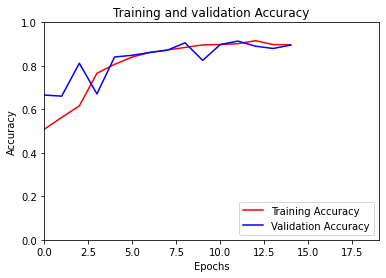

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc=History[0].history['accuracy']
val_acc=History[0].history['val_accuracy']
loss=History[0].history['loss']
val_loss=History[0].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.00,1.00))
plt.xlim([0,19])
plt.title("Training and validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

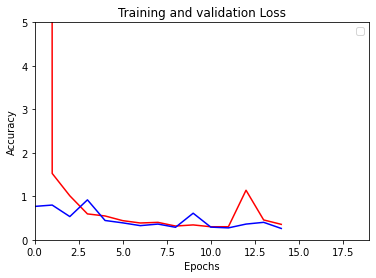

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss")
plt.ylim((0.00,5.00))
plt.xlim([0,19])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="upper right")
plt.figure()

<Figure size 432x288 with 0 Axes>

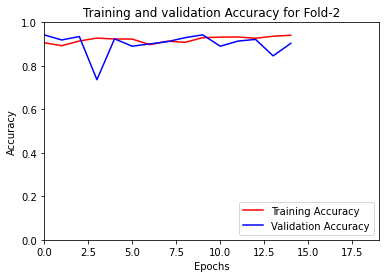

<Figure size 432x288 with 0 Axes>

In [ ]:
acc=History[1].history['accuracy']
val_acc=History[1].history['val_accuracy']
loss=History[1].history['loss']
val_loss=History[1].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.00,1.00))
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-2")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

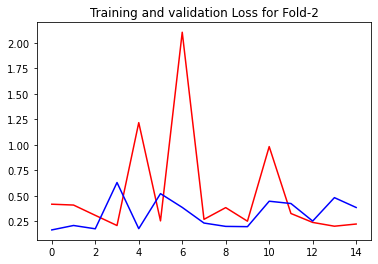

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss for Fold-2")
plt.figure()

<Figure size 432x288 with 0 Axes>

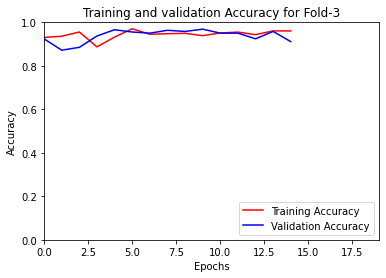

<Figure size 432x288 with 0 Axes>

In [ ]:
acc=History[2].history['accuracy']
val_acc=History[2].history['val_accuracy']
loss=History[2].history['loss']
val_loss=History[2].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.00,1.00))
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-3")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

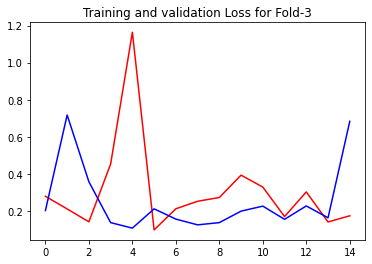

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r')
plt.plot(epochs,val_loss,'b')
plt.title("Training and validation Loss for Fold-3")
plt.figure()

<Figure size 432x288 with 0 Axes>

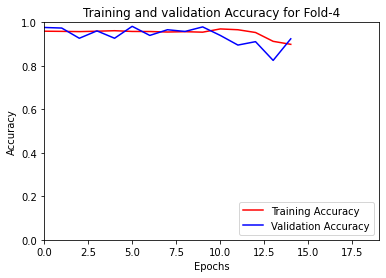

<Figure size 432x288 with 0 Axes>

In [ ]:
acc=History[3].history['accuracy']
val_acc=History[3].history['val_accuracy']
loss=History[3].history['loss']
val_loss=History[3].history['val_loss']

epochs=range(len(acc))

plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim((0.00,1.00))
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-4")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.figure()

<Figure size 432x288 with 0 Axes>

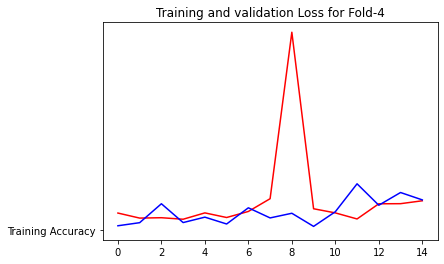

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-4")
plt.figure()

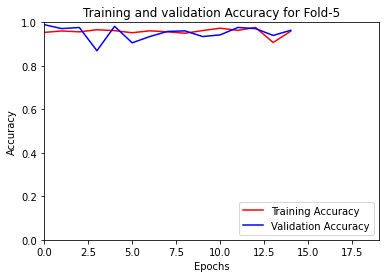

In [ ]:
acc=History[4].history['accuracy']
val_acc=History[4].history['val_accuracy']
loss=History[4].history['loss']
val_loss=History[4].history['val_loss']

epochs=range(len(acc))
plt.figure()
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim([0.00,1.00])
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-5")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

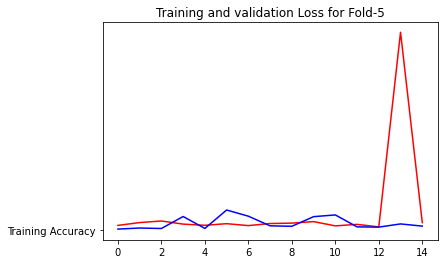

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-5")
plt.figure()

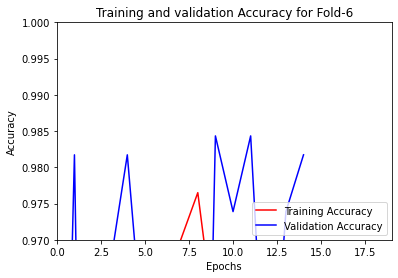

In [ ]:
acc=History[5].history['accuracy']
val_acc=History[5].history['val_accuracy']
loss=History[5].history['loss']
val_loss=History[5].history['val_loss']

epochs=range(len(acc))
plt.figure()
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim([0.97,1.00])
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-6")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

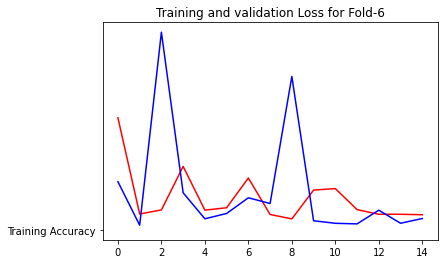

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-6")
plt.figure()

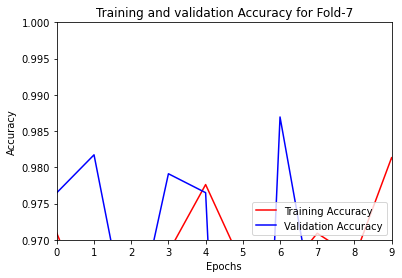

In [ ]:
acc=History[6].history['accuracy']
val_acc=History[6].history['val_accuracy']
loss=History[6].history['loss']
val_loss=History[6].history['val_loss']

epochs=range(len(acc))
plt.figure()
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim([0.97,1.00])
plt.xlim([0,9])
plt.title("Training and validation Accuracy for Fold-7")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

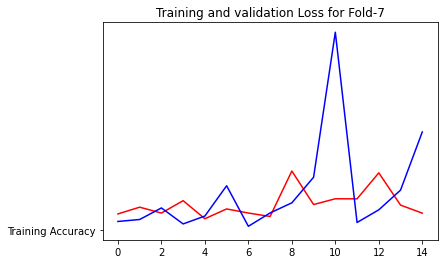

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-7")
plt.figure()

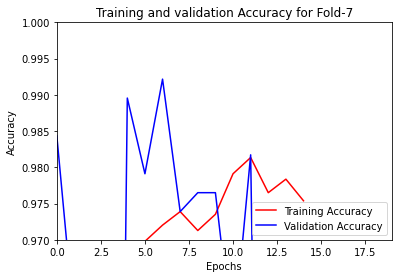

In [ ]:
acc=History[7].history['accuracy']
val_acc=History[7].history['val_accuracy']
loss=History[7].history['loss']
val_loss=History[7].history['val_loss']

epochs=range(len(acc))
plt.figure()
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.ylim([0.97,1.00])
plt.xlim([0,19])
plt.title("Training and validation Accuracy for Fold-7")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

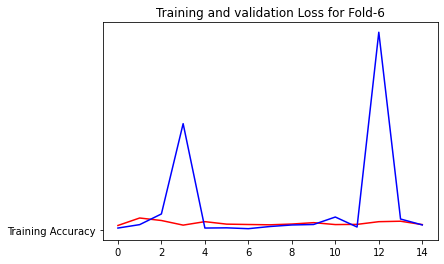

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r','Training Accuracy')
plt.plot(epochs,val_loss,'b','Training Accuracy')
plt.title("Training and validation Loss for Fold-6")
plt.figure()

In [ ]:
y_predict=model.predict(X_dataset)

In [ ]:
Y_predict=np.argmax(y_predict,axis=1)

In [ ]:
#print(Y_predict)
Y_predict=np.reshape(Y_predict,(3064,1))
print(Y_predict)

[[0]
 [0]
 [0]
 ...
 [1]
 [0]
 [0]]


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
metrics=confusion_matrix(Y_dataset,Y_predict)
print(metrics)

[[ 702    6    0]
 [  30 1390    6]
 [   5    3  922]]


In [ ]:
from sklearn.metrics import precision_score

In [ ]:
prescore=precision_score(Y_dataset,Y_predict,average=None)

In [ ]:
print(prescore)

[0.95251018 0.99356683 0.99353448]


In [ ]:
from sklearn.metrics import recall_score

In [ ]:
recaller=recall_score(Y_dataset,Y_predict,average=None)

In [ ]:
print(recaller)

[0.99152542 0.97475456 0.99139785]


In [ ]:
from sklearn.metrics import f1_score

In [ ]:
score=f1_score(Y_dataset,Y_predict,average=None)

In [ ]:
print(score)

[0.9716263  0.9840708  0.99246502]


In [ ]:
#Printing ROC 
from sklearn.preprocessing import label_binarize

In [ ]:
lb=label_binarize(Y_dataset,classes=[0,1,2])
print(lb)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]


In [ ]:
lb1=label_binarize(Y_predict,classes=[0,1,2])
print(lb1)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [0 1 0]
 [1 0 0]
 [1 0 0]]


In [ ]:
from sklearn.metrics import auc,roc_curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(lb[:, i], lb1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

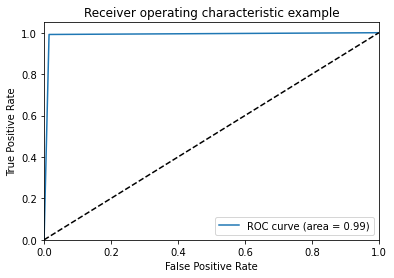

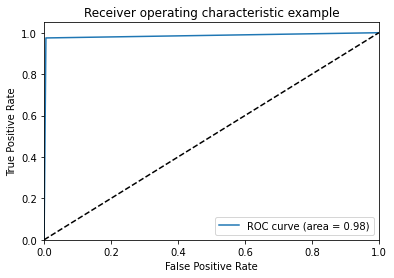

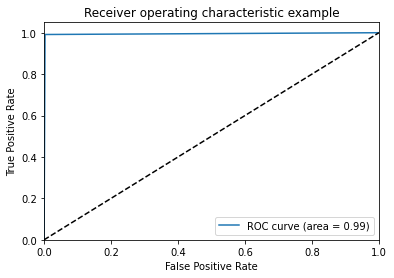

In [ ]:
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()